### Laplace Mechanism for Differential Privacy

Here we construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [1]:
import numpy as np

def laplace(shift=0., scale=1., size=None):
    """Sample from the laplace distribution."""
    p = np.random.uniform(low=0, high=1, size=size)
    draws = shift - scale * np.log(1 - p).  # fix this
    return draws

    # the easy way
    # return np.random.laplace(loc=shift, scale=scale, size=size)


def clamp(x, bounds):
    """Replace any x_i less than lower with lower,
           and any x_i greater than upper with upper."""
    lower, upper = bounds
    x_clamped = x.copy()
    # fix this
    return x_clamped

    # the easy way
    # return np.clip(x, *bounds)


def bounded_mean(x, bounds):
    lower = min(x)
    upper = max(x)
    bounds = (lower, upper) # fix this

    x_clamped = clamp(x, bounds)
    bounded_mean = np.mean(x_clamped)
    return bounded_mean

    # the easy way
    # return np.mean(clamp(x,bounds))


def release_dp_mean(x, bounds, epsilon):
    """Release a DP mean.
    Assumes that the dataset size n is public information.
    """

    # privatize
    n = len(x)
    lower, upper = bounds
    sensitivity = 1 # fix this
    scale = sensitivity/epsilon

    sensitive_answer = bounded_mean(x, bounds)

    dp_mean = sensitive_answer # fix this
    return dp_mean

    # the compact way
    # return laplace(shift=mean(x_clamped(x)), scale=(upper-lower)/(n*epsilon))


Read in the data.  We're going to use the PUMS dataset we are familiar with, and focus on the education variable, a 16 point scale.

In [2]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

# define public information
n = len(data)            # in this case, dataset length is considered public, and is not protected
educ_bounds = (1., 16.)  # easily guessable without looking at the data

educ = data['educ'].values.astype(float)
print(release_dp_mean(educ, bounds=educ_bounds, epsilon=1.))

10.609234878885358


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using.

In [3]:
def release_histogram(x, epsilon, categories):
    sensitivity = 1
    scale = sensitivity/epsilon

    # sensitive_histogram = np.histogram(x, bins=categories)[0]  # [0] is counts [1] is bins

    # create a {category: count} hashmap
    counts = dict(zip(*np.unique(x, return_counts=True)))
    # look up the count of each category, or zero if not exists
    sensitive_histogram = np.array([counts.get(cat, 0) for cat in categories])

    dp_histogram = sensitive_histogram + laplace(scale=scale, size=sensitive_histogram.shape)
    return dp_histogram


Let's call our privacy-preserving histogram.

In [4]:
educ_categories = list(range(1, 17))
output = release_histogram(educ, epsilon=1., categories=educ_categories)

print(output)

[ 271.966385    141.64099427  355.50977849  469.50345383  496.43555834
  757.28719051  894.94969362 1060.89484429 5148.26313083 1396.63623474
 3963.91095712 1160.06962767 6284.30957994 2266.7960842   796.38782181
  308.22597071]


We're going to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable.  

We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [5]:
import math

def bootstrap(x, n):
    """Sample n values with replacement from n."""
    index = np.random.randint(low=0., high=len(x), size=n)
    return x[index]

    # the easy way
    # return np.random.choice(x, size=n)


n_sims = 1000

log_seq = np.linspace(start=math.log10(200), stop=math.log10(1500), num=15)
n_seq = (10**log_seq).astype(int)
print(n_seq)


log_seq = np.linspace(start=math.log10(1), stop=math.log10(0.1), num=5)
ep_seq = (10**log_seq *100).astype(int)/100
print(ep_seq)

agg_history = []

aggcount = 0

for i, n_sim in enumerate(n_seq):
    for j, epsilon_sim in enumerate(ep_seq):
        sq_error = 0

        for k in range(n_sims):
            bootdata = bootstrap(educ, n_sim)
            sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
            dp_mean = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim)
            sq_error += (dp_mean - sensitive_mean) ** 2

        agg_history.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error/n_sims)  #RMSE
        ])

        aggcount += 1

agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "error"])


[ 200  230  266  307  355  410  474  547  632  730  843  974 1124 1298
 1500]
[1.   0.56 0.31 0.17 0.1 ]


Graphing our results is often a case of finding an approximate template and then tweaking it to convey the exact details of interest to your reader.  This template for showing the utility of DP releases will likely be commonly useful across your homeworks and project.

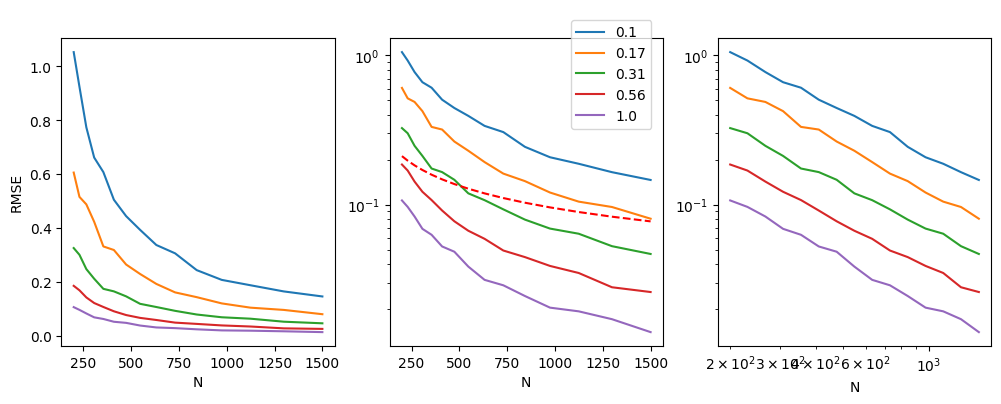

In [6]:

import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="error", label=epsilon_sim, ax=ax, legend=None)

## Overlay the standard error of the mean
se = np.std(educ) / np.sqrt(n_seq)
axs[1].plot(n_seq, se, linestyle='dashed', color="red")

_ = fig.legend(*axs[0].get_legend_handles_labels(), loc=(0.57, 0.68))
